In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import data into dataframe
df = pd.read_csv('../input/heart.csv')

In [2]:
# quick peek
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Attribute Information: 
> 1. age 
> 2. sex 
> 3. chest pain type (4 values) 
> 4. resting blood pressure 
> 5. serum cholestoral in mg/dl 
> 6. fasting blood sugar > 120 mg/dl
> 7. resting electrocardiographic results (values 0,1,2)
> 8. maximum heart rate achieved 
> 9. exercise induced angina 
> 10. oldpeak = ST depression induced by exercise relative to rest 
> 11. the slope of the peak exercise ST segment 
> 12. number of major vessels (0-3) colored by flourosopy 
> 13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

# Preprocessing

In [3]:
# check for null values
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
# split into inputs and targets
X = df.drop('target',axis=1)
y = df['target']

In [6]:
# Feature normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [7]:
# split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y)

# Train some models

## Logistic Regression

Find the optimal parameters with validation curves. The model will be optimized via cross validation on the F1 score, which combines Precision and recall. Ideally I would set the focus on recall as this is a medical classification and I want to avoid false positives as much as possible (Who wants a false heart attack prediction?)

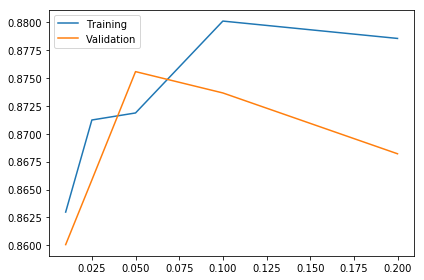

In [8]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
import numpy as np

clf = LogisticRegression(solver="lbfgs")
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import seaborn as sns

param_range = [0.01,0.025,0.05,0.1,0.2]
train_scores, valid_scores = validation_curve(clf, X_train, y_train,
                                              "C",param_range,
                                              cv=5,scoring="f1")

train_mean = np.mean(train_scores,axis=1)
valid_mean = np.mean(valid_scores,axis=1)

plt.plot(param_range, train_mean, label="Training")
plt.plot(param_range, valid_mean, label="Validation")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

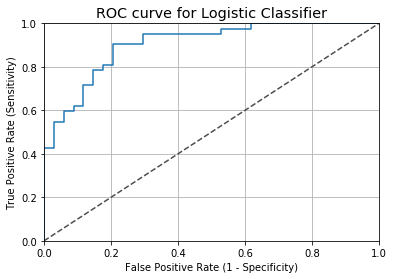

In [9]:
from sklearn.metrics import roc_curve

clf = LogisticRegression(solver="lbfgs", C=0.1).fit(X_train, y_train)
y_pred_quant = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Logistic Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [10]:
from sklearn.metrics import auc
print(auc(fpr, tpr))

0.9047619047619048


AUC is 0.89 - it's in the upper "good" range.

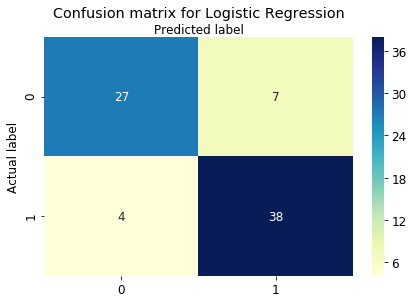

In [11]:
from sklearn.metrics import confusion_matrix
predict = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test,predict)

class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

#create a heat map
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu',
           fmt = 'g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix for Logistic Regression', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

More false positives than negatives.

## Gradient Boosting Decision tree
same idea here. Try to find the best hyperparameters with validation curves with a F1 scorer

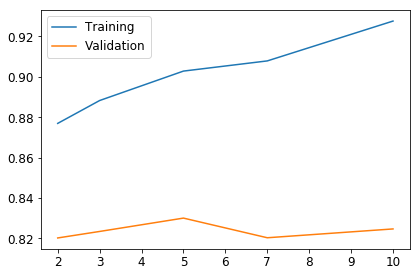

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

param_range = [2,3,5,7,10]
train_scores, valid_scores = validation_curve(clf, X_train, y_train,
                                              "n_estimators",param_range,
                                              cv=5,scoring="f1")

train_mean = np.mean(train_scores,axis=1)
valid_mean = np.mean(valid_scores,axis=1)

plt.plot(param_range, train_mean, label="Training")
plt.plot(param_range, valid_mean, label="Validation")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

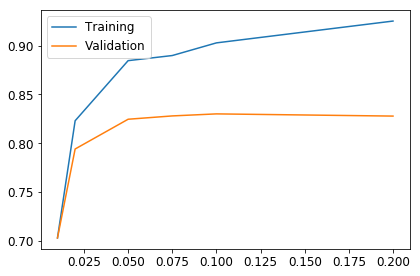

In [13]:
clf = GradientBoostingClassifier(n_estimators=5)

param_range = [0.01,0.02,0.05,0.075,0.1,0.2]
train_scores, valid_scores = validation_curve(clf, X_train, y_train,
                                              "learning_rate",param_range,
                                              cv=5,scoring="f1")

train_mean = np.mean(train_scores,axis=1)
valid_mean = np.mean(valid_scores,axis=1)

plt.plot(param_range, train_mean, label="Training")
plt.plot(param_range, valid_mean, label="Validation")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

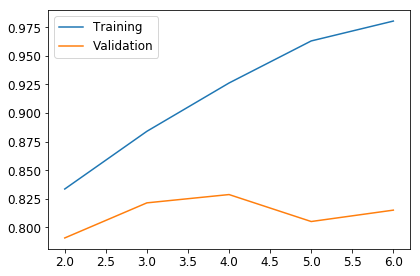

In [14]:
clf = GradientBoostingClassifier(n_estimators=3, learning_rate=0.075)

param_range = [2,3,4,5,6]
train_scores, valid_scores = validation_curve(clf, X_train, y_train,
                                              "max_depth",param_range,
                                              cv=5,scoring="f1")

train_mean = np.mean(train_scores,axis=1)
valid_mean = np.mean(valid_scores,axis=1)

plt.plot(param_range, train_mean, label="Training")
plt.plot(param_range, valid_mean, label="Validation")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

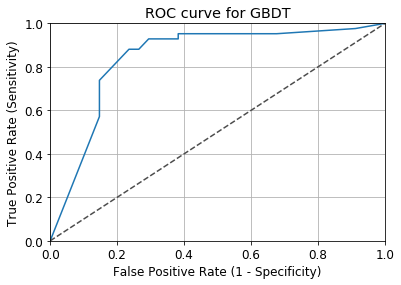

In [15]:
clf = GradientBoostingClassifier(n_estimators=3, learning_rate=0.05, max_depth=4).fit(X_train, y_train)
y_pred_quant = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for GBDT')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [16]:
from sklearn.metrics import auc
print(auc(fpr, tpr))

0.8420868347338936


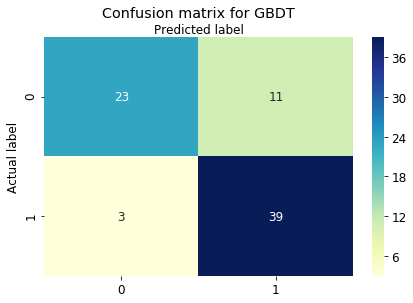

In [17]:
predict = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test,predict)

class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

#create a heat map
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu',
           fmt = 'g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix for GBDT', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

GDBT performs a bit better in terms of false positives.